In [1]:
from IPython.display import display
import os

if "SSH_CONNECTION" in os.environ:
    display("Running via SSH")
else:
    display("Running locally")

'Running via SSH'

In [2]:
import sys
import os

path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/TB-PNCA-GNN') if "SSH_CONNECTION" not in os.environ else os.path.join('..', '/mnt/alphafold-volume-1/dylan2/repos/tb-pnca-gnn')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

import datetime
import random

import numpy as np
import pandas as pd
import copy
import pickle

import torch
from torch_geometric.data import Data

import wandb

import sbmlcore
import sbmlsim
import gumpy

import warnings
warnings.filterwarnings('ignore')

from src import run_model, protein_graph, gcn_model, evaluation

%load_ext autoreload
%autoreload 2

%aimport src

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
torch.cuda.is_available()

True

### Snap2

In [5]:
snap2_df = pd.read_csv('../data/features/3pl1-snap2-with-segids.csv')
snap2_df

,Variant,Predicted Effect,Score,Expected Accuracy,segid
0,M1A,effect,39,66%,A
1,M1R,effect,44,71%,A
2,M1N,effect,59,75%,A
3,M1D,effect,74,85%,A
4,M1C,effect,9,53%,A
...,...,...,...,...,...
3715,S186S,neutral,-79,87%,A
3716,S186T,neutral,-73,87%,A
3717,S186W,effect,45,71%,A
3718,S186Y,effect,38,66%,A


In [31]:
snap2_df[snap2_df['Score'] == 5].head(50)

,Variant,Predicted Effect,Score,Expected Accuracy,segid
36,R2T,effect,5,53%,A
110,I6L,effect,5,53%,A
438,T22Y,effect,5,53%,A
842,H43N,effect,5,53%,A
1095,G55S,effect,5,53%,A
1521,P77R,effect,5,53%,A
1857,V93W,effect,5,53%,A
1947,A98G,effect,5,53%,A
3089,V155I,effect,5,53%,A


In [72]:
snap2 = sbmlcore.SNAP2('../data/features/3pl1-snap2-with-segids.csv', offsets={'A': 0}).results
snap2

,mutation,snap2_effect,snap2_score,snap2_accuracy,segid,alt_amino_acid,resid,chain_offsets
0,M1A,effect,39,66,A,A,1,0
1,M1R,effect,44,71,A,R,1,0
2,M1N,effect,59,75,A,N,1,0
3,M1D,effect,74,85,A,D,1,0
4,M1C,effect,9,53,A,C,1,0
...,...,...,...,...,...,...,...,...
3715,S186S,neutral,-79,87,A,S,186,0
3716,S186T,neutral,-73,87,A,T,186,0
3717,S186W,effect,45,71,A,W,186,0
3718,S186Y,effect,38,66,A,Y,186,0


In [75]:
snap2[['mutation', 'snap2_score']]

,mutation,snap2_score
0,M1A,39
1,M1R,44
2,M1N,59
3,M1D,74
4,M1C,9
...,...,...
3715,S186S,-79
3716,S186T,-73
3717,S186W,45
3718,S186Y,38


<Axes: >

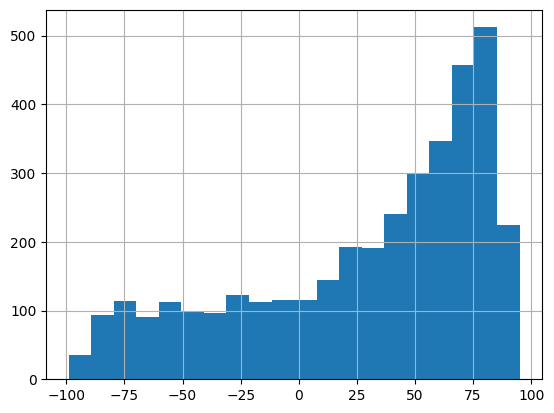

In [78]:
snap2.snap2_score.hist(bins=20)

In [ ]:
# snap2 scales from -100 to 100, where -100 indicates no change in effect, 0 indicates a 50% chance in a change in effect, and 100 a certain change in effect 
# featurise where -100 = 0, 0 = 0.5, 100 = 1

# where there is an amino acid change, attach the score. WT residue, attach -100. Then normalise at the end

### DeepDDG

In [92]:
deepddg = sbmlcore.DeepDDG('../data/features/3pl1.ddg').results
deepddg

,segid,ref_amino_acid,resid,alt_amino_acid,deep_ddG
0,A,M,1,A,-0.879
1,A,M,1,R,-0.780
2,A,M,1,N,-1.003
3,A,M,1,D,-0.903
4,A,M,1,C,-0.899
...,...,...,...,...,...
3510,A,S,185,P,-0.929
3511,A,S,185,T,-0.642
3512,A,S,185,W,-0.212
3513,A,S,185,Y,-0.749


<Axes: >

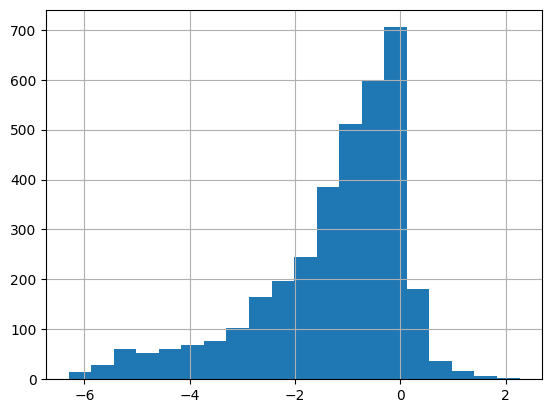

In [68]:
deepddg.deep_ddG.hist(bins = 20)

In [ ]:
# WT residues attach as 0, then normalise

### RaSP

In [56]:
rasp = sbmlcore.RaSP('../data/features/cavity_pred_3PL1_A.csv').results
rasp

,segid,rasp_wt_nlf,rasp_mt_nlf,rasp_score_ml_fermi,rasp_score_ml,resid,ref_amino_acid,alt_amino_acid
0,A,3.785957,2.483982,0.288779,0.746696,1,M,A
1,A,3.785957,4.335140,0.336359,1.301094,1,M,C
2,A,3.785957,2.824680,0.307895,0.975053,1,M,D
3,A,3.785957,2.712832,0.286746,0.721894,1,M,E
4,A,3.785957,3.207937,0.202529,-0.426406,1,M,F
...,...,...,...,...,...,...,...,...
3695,A,2.844502,2.844502,0.222293,-0.130889,185,S,S
3696,A,2.844502,2.896883,0.212737,-0.271257,185,S,T
3697,A,2.844502,2.623741,0.168936,-0.982962,185,S,V
3698,A,2.844502,4.250501,0.249608,0.248246,185,S,W


<Axes: >

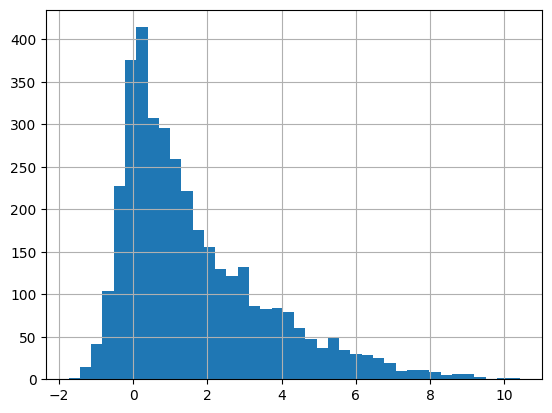

In [107]:
rasp.rasp_score_ml.hist(bins=40)

In [ ]:
# Use rasp_score_ml and attach WT as 0, then normalise

### MAPP

In [51]:
df = pd.read_csv('../data/features/3pl1-mapp_scores.csv')
mapp = pd.melt(df, id_vars='Position',value_vars=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
mapp.rename(columns={'Position': 'codon', 'variable': 'alt_amino_acid', 'value': 'mapp_score'}, inplace=True)
mapp.set_index(['codon', 'alt_amino_acid'], inplace=True)

def split_mutation(row):
    return pd.Series([int(row.mutation[1:-1]), row.mutation[-1]])

mapp

,,mapp_score
codon,alt_amino_acid,
1,A,20.48
2,A,4.50
3,A,1.24
4,A,5.36
5,A,10.25
...,...,...
182,Y,3.15
183,Y,3.86
184,Y,3.39


array([[<Axes: title={'center': 'mapp_score'}>]], dtype=object)

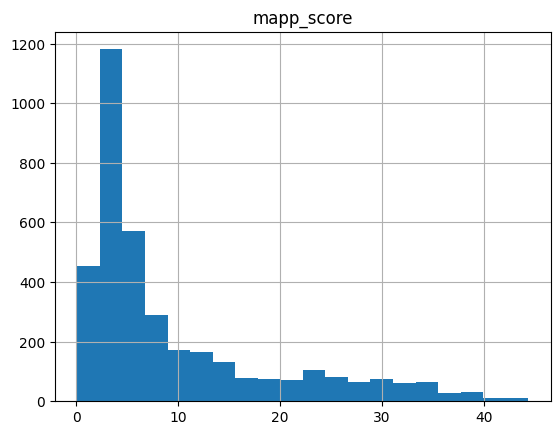

In [69]:
mapp.hist(bins=20)

In [ ]:
# Attach WT residues as 0, then normalise

### Create feature df

In [358]:
resids = pd.DataFrame(pnca.build_resids(train_seqs.allele[0]), columns=['segid', 'amino_acid', 'resid'])
resids = pd.DataFrame(resids[:-2], columns=['segid', 'amino_acid', 'resid'])
resids = pd.concat([resids, pd.DataFrame(list(wt_seq), columns=['ref'])], axis=1)

In [375]:
pd.DataFrame(list(wt_seq), columns=['ref'])

,ref
0,M
1,R
2,A
3,L
4,I
...,...
180,E
181,L
182,V
183,C


In [359]:
resids['mutation'] = resids.apply(
    lambda row: f"{row['ref']}{row['resid']}{row['amino_acid']}" 
    if row['amino_acid'] != row['ref'] else None, 
    axis=1
)

In [360]:
features = sbmlcore.FeatureDataset(resids,species='M. tuberculosis', gene='pncA', protein='PncA')
features

species:          M. tuberculosis
gene name:        pncA
protein name:     PncA
number of rows:   185

  segid amino_acid resid ref mutation
0     A          M     1   M     None
1     A          R     2   R     None
2     A          A     3   A     None

In [361]:
# snap2
def attach_snap2(df):
    
    assert "snap2_score" not in df.columns, "Snap2 already added"
    
    assert (
            "mutation" in df.columns
        ), "Passed dataframe must contain a column called mutation"
    
    snap2 = sbmlcore.SNAP2('../data/features/3pl1-snap2-with-segids.csv', offsets={'A': 0})
    
    df = pd.merge(df, snap2.results[['mutation', 'snap2_score']], on='mutation', how='left')
    df['snap2_score'] = df['snap2_score'].fillna(-100)
    
    return df

In [369]:
# deepddg
def attach_deepddg(df):
        
    assert "deep_ddG" not in df.columns, "DeepDDG already added"
    
    deepddg = sbmlcore.DeepDDG('../data/features/3pl1.ddg')
    
    df = pd.merge(df, deepddg.results, 
                        left_on=['segid', 'ref', 'resid', 'amino_acid'], 
                        right_on=['segid', 'ref_amino_acid', 'resid', 'alt_amino_acid'],
                        how='left')
    df.drop(columns = ['ref_amino_acid', 'alt_amino_acid'], inplace=True)
    df['deep_ddG'] = df['deep_ddG'].fillna(0.0)
    
    return df

In [370]:
# rasp
def attach_rasp(df):
    
    assert "rasp_score_ml" not in df.columns, "RaSP already added"

    rasp = sbmlcore.RaSP('../data/features/cavity_pred_3PL1_A.csv')
    
    df = pd.merge(df, rasp.results, 
                        left_on=['segid', 'ref', 'resid', 'amino_acid'], 
                        right_on=['segid', 'ref_amino_acid', 'resid', 'alt_amino_acid'],
                        how='left')
    df.drop(columns = ['ref_amino_acid', 'alt_amino_acid', 'rasp_wt_nlf', 'rasp_mt_nlf', 'rasp_score_ml_fermi'], inplace=True)

    df['rasp_score_ml'] = np.where(
        df['mutation'].isna(),
        0.0,
        df['rasp_score_ml']
    )
    
    return df

In [371]:
# mapp
def attach_mapp(df):
    
    assert "mapp_score" not in df.columns, "MAPP already added"    
    
    mapp_df = pd.read_csv('../data/features/3pl1-mapp_scores.csv')
    mapp = pd.melt(mapp_df, id_vars='Position',value_vars=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
    mapp.rename(columns={'Position': 'codon', 'variable': 'alt_amino_acid', 'value': 'mapp_score'}, inplace=True)

    df = pd.merge(df, mapp, 
                        left_on=['resid', 'amino_acid'], 
                        right_on=['codon','alt_amino_acid'],
                        how='left')
    df.drop(columns = ['codon', 'alt_amino_acid'], inplace=True)


    df['mapp_score'] = np.where(
        df['mutation'].isna(),
        0.0,
        df['mapp_score']
    )
    
    return df

### Check features df

In [372]:
features.df = attach_snap2(features.df)
features.df = attach_deepddg(features.df)
features.df = attach_rasp(features.df)
features.df = attach_mapp(features.df)

In [373]:
features.df[features.df['mutation'].notna()]

,segid,amino_acid,resid,ref,mutation,snap2_score,deep_ddG,rasp_score_ml,mapp_score
101,A,V,102,A,A102V,73.0,-1.389,1.093222,5.08


In [390]:
features.df.head()

,segid,amino_acid,resid,ref,mutation,snap2_score,deep_ddG,rasp_score_ml,mapp_score
0,A,M,1,M,None,-100.0,0.0,0.0,0.0
1,A,R,2,R,None,-100.0,0.0,0.0,0.0
2,A,A,3,A,None,-100.0,0.0,0.0,0.0
3,A,L,4,L,None,-100.0,0.0,0.0,0.0
4,A,I,5,I,None,-100.0,0.0,0.0,0.0


### Add to feature tensor

In [7]:
train_seqs = pd.read_csv('../data/real_train_sequences.csv')
test_seqs = pd.read_csv('../data/real_test_sequences.csv')
wt_seq = 'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS'

In [384]:
train_seqs

,phenotype_label,number_resistant_mutations,number_susceptible_mutations,allele
0,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
1,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
2,R,1,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
3,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
4,R,1,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
...,...,...,...,...
459,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDHLAEAADYHHVVA...
460,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
461,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
462,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...


In [378]:
pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                    lig_resname='PZA', 
                    self_loops=False,
                    cutoff_distance=8)

In [389]:
pnca.gen_dataset(wt_seq,
                 train_seqs,
                 '1-(dist/cutoff)')

100%|██████████| 464/464 [02:01<00:00,  3.82it/s]


In [394]:
dataset =  pnca.dataset
pd.DataFrame(dataset[38].x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,162.899994,-0.44,149.199997,5.74,1.9,0.0,0.0,0.0,27.641663,0.000000,-35.200001,86.199997,-100.0,0.00,0.000000,0.00
1,173.399994,1.00,174.199997,10.76,-4.5,0.0,5.0,0.0,24.722696,-117.940002,133.990005,54.700001,-100.0,0.00,0.000000,0.00
2,138.399994,1.61,147.100006,3.22,-3.5,4.0,0.0,0.0,21.557457,-126.529999,153.850006,0.000000,56.0,-5.34,3.546088,35.68
3,166.699997,-0.69,131.199997,5.98,3.8,0.0,0.0,0.0,18.780048,-103.239998,132.399994,0.200000,-100.0,0.00,0.000000,0.00
4,166.699997,-0.81,131.199997,6.02,4.5,0.0,0.0,0.0,15.158482,-113.699997,111.879997,0.200000,-100.0,0.00,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,138.399994,1.61,147.100006,3.22,-3.5,4.0,0.0,0.0,21.844889,-91.730003,121.849998,105.500000,-100.0,0.00,0.000000,0.00
181,166.699997,-0.69,131.199997,5.98,3.8,0.0,0.0,0.0,20.530870,-106.699997,110.910004,50.599998,-100.0,0.00,0.000000,0.00
182,140.000000,-0.53,117.099998,5.96,4.2,0.0,0.0,0.0,22.453640,-134.360001,166.850006,33.799999,-100.0,0.00,0.000000,0.00
183,108.500000,0.22,121.199997,5.07,2.5,0.0,0.0,0.0,22.603352,-92.410004,154.119995,95.400002,-100.0,0.00,0.000000,0.00


In [395]:
# now stack all dfs and normalise by column

all_features = torch.cat([data.x for data in dataset], dim=0)

In [402]:
pd.DataFrame(all_features).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000,85840.000000
mean,125.226639,0.456176,123.446945,5.740922,0.005613,1.058737,0.590401,0.162162,16.293013,-72.490273,42.154213,46.761078,-99.308540,-0.006657,0.008487,0.054496
std,38.441532,0.930408,29.203501,1.613056,2.892200,1.459335,1.151743,0.396849,5.477823,56.851006,90.893333,44.588604,10.102626,0.130125,0.175934,1.044644
min,60.099998,-0.810000,75.099998,2.770000,-4.500000,0.000000,0.000000,0.000000,5.778265,-161.660004,-179.500000,0.000000,-100.000000,-6.301000,-1.362533,0.000000
25%,89.000000,-0.440000,105.099998,5.600000,-3.200000,0.000000,0.000000,0.000000,11.347777,-109.129997,-36.130001,7.100000,-100.000000,0.000000,0.000000,0.000000
50%,116.099998,0.330000,119.099998,5.960000,-0.700000,0.000000,0.000000,0.000000,15.610257,-73.760002,14.020000,37.299999,-100.000000,0.000000,0.000000,0.000000
75%,153.199997,1.140000,133.100006,6.000000,2.500000,2.000000,1.000000,0.000000,20.348066,-58.110001,134.490005,78.099998,-100.000000,0.000000,0.000000,0.000000
max,227.800003,2.410000,204.199997,10.760000,4.500000,4.000000,5.000000,2.000000,28.399427,123.629997,179.389999,189.600006,94.000000,2.261000,8.923580,44.360001


In [406]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(all_features.numpy())

MinMaxScaler()

In [419]:
# Apply normalization to each graph
for data in dataset:
    data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)

In [421]:
dataset[38].x

tensor([[0.6130, 0.1149, 0.5740,  ..., 0.7359, 0.1325, 0.0000],
        [0.6756, 0.5621, 0.7676,  ..., 0.7359, 0.1325, 0.0000],
        [0.4669, 0.7516, 0.5577,  ..., 0.1122, 0.4772, 0.8043],
        ...,
        [0.4764, 0.0870, 0.3253,  ..., 0.7359, 0.1325, 0.0000],
        [0.2886, 0.3199, 0.3571,  ..., 0.7359, 0.1325, 0.0000],
        [0.1723, 0.3540, 0.2324,  ..., 0.7359, 0.1325, 0.0000]])

### Test

In [9]:
pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                    lig_resname='PZA', 
                    self_loops=False,
                    cutoff_distance=8)

pnca.gen_dataset(wt_seq,
                 train_seqs,
                 '1-(dist/cutoff)')

train_dataset = pnca.dataset

100%|██████████| 464/464 [07:54<00:00,  1.02s/it]


In [10]:
pnca.gen_dataset(wt_seq,
                 test_seqs,
                 '1-(dist/cutoff)')

test_dataset = pnca.dataset

  0%|          | 1/200 [00:00<02:52,  1.15it/s]

100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


In [11]:
full_dataset = train_dataset + test_dataset

torch.save(full_dataset, 'datasets/full_real_dataset_v2.pth')